First pre-optimization image:


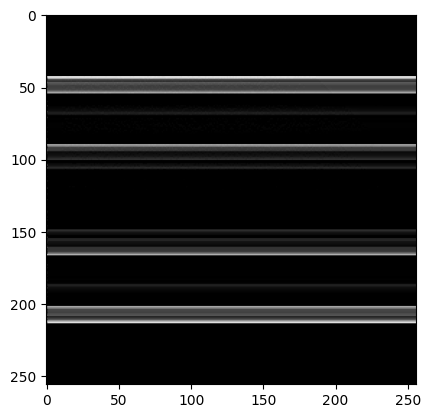

In [1]:
import numpy as np
import os
import sys
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from PIL import Image

# Set the paths to the image folders
pre_optimization_folder = 'D:/archive/members/mark/256x256/SpeedTestDump/'
save_path = 'D:/archive/members/mark/MLResults/'
modelFile = "./model_256x256_200.pth"
optionalPlot = False
optionalSave = False
file_index = 56 
batch_size = 90

start_time = time.time()

# Function to load grayscale images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return images

# Load pre-optimization grayscale images
pre_optimization_images = load_images_from_folder(pre_optimization_folder)

# Convert image lists to numpy arrays
pre_optimization_images = np.array(pre_optimization_images)

# Normalize the image data
pre_optimization_images = pre_optimization_images / 255.0

# Convert numpy arrays to PyTorch tensors
x_train = torch.from_numpy(pre_optimization_images).unsqueeze(1).float()


print("First pre-optimization image:")
plt.imshow(pre_optimization_images[0], cmap='gray')
plt.show()


In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.middle_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        )

        self.decoder = nn.Sequential(
            
            nn.Conv2d(192, 64, kernel_size=3, padding=1),  # Concatenating feature maps from the encoder
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        encoder_output1 = self.encoder(x)
        encoder_output2 = self.middle_conv(encoder_output1)
        decoder_input = torch.cat([encoder_output2, encoder_output1], dim=1)  # Concatenate feature maps
        decoder_output = self.decoder(decoder_input)
        return decoder_output
  
    
model = UNet()
model.load_state_dict(torch.load(modelFile))
model.eval()



UNet(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (middle_conv): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): GELU(approximate='none')
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): GELU(approximate='none')
    (5): Upsample(scale_factor=2.0, mode='bilinear')
  )
  (decoder): Sequential(
    (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import time
import os
import sys
import cv2

device_count = torch.cuda.device_count()
if device_count > 0:
    print("Available GPUs:")
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available. PyTorch is using CPU.")

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    model = model.to(device)
    print("PyTorch is using GPU.")
else:
    print("PyTorch is using CPU.")

# Convert the data to the appropriate device
x_train = x_train.to(device)

dataset = TensorDataset(x_train)

# Create PyTorch DataLoaders for training and validation
dataloader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=False)



Available GPUs:
GPU 0: NVIDIA RTX A5000
PyTorch is using GPU.


In [4]:
import matplotlib.pyplot as plt

example_inputs = []
example_outputs = []

count = 0
# Iterate through batches from the validation dataloader
for batch in dataloader:
    print("Batch No. " + str(count))
    batch_inputs = batch[0]
    batch_inputs = batch_inputs.to(device)

    # Forward pass through the model
    with torch.no_grad():
        batch_outputs = model(batch_inputs)

    # Convert the tensors to numpy arrays
    batch_inputs = batch_inputs.cpu().numpy()
    batch_outputs = batch_outputs.cpu().numpy()


    # Reshape the example inputs and outputs if needed
    # (Assuming the inputs and outputs have shape (batch_size, channels, height, width))
    batch_inputs = batch_inputs.transpose(0, 2, 3, 1)
    batch_outputs = batch_outputs.transpose(0, 2, 3, 1)

    #Create the final list containing the inputs and outputs for all files instead instead of just one batch
    example_inputs.append(batch_inputs)
    example_outputs.append(batch_outputs)
    count+=1


# Plot the example inputs, targets, and outputs

#Optionally plots the output for a single file index:
#file_index should be divisible by (360/batch_size)

if optionalPlot:
    for factor in range ((int)(360/batch_size)):
        for i in range ((int)(batch_size/5)):
            plt.figure(figsize=(16, 7))
            for j in range(5):
                plt.subplot(2, 5, j+1)
                plt.imshow(example_inputs[file_index+factor][i*5+j])
                plt.title('Input')
                plt.axis('off')

                plt.subplot(2, 5, 5 + j + 1)
                plt.imshow(example_outputs[file_index+factor][i*5+j])
                plt.title('Output')
                plt.axis('off')
            plt.tight_layout()
            plt.show()

end_time = time.time()
print(end_time-start_time)
    

Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Batch No. 9
Batch No. 10
Batch No. 11
Batch No. 12
Batch No. 13
Batch No. 14
Batch No. 15
Batch No. 16
Batch No. 17
Batch No. 18
Batch No. 19
Batch No. 20
Batch No. 21
Batch No. 22
Batch No. 23
Batch No. 24
Batch No. 25
Batch No. 26
Batch No. 27
Batch No. 28
Batch No. 29
Batch No. 30
Batch No. 31
Batch No. 32
Batch No. 33
Batch No. 34
Batch No. 35
Batch No. 36
Batch No. 37
Batch No. 38
Batch No. 39
Batch No. 40
Batch No. 41
Batch No. 42
Batch No. 43
Batch No. 44
Batch No. 45
Batch No. 46
Batch No. 47
Batch No. 48
Batch No. 49
Batch No. 50
Batch No. 51
Batch No. 52
Batch No. 53
Batch No. 54
Batch No. 55
Batch No. 56
Batch No. 57
Batch No. 58
Batch No. 59
Batch No. 60
Batch No. 61
Batch No. 62
Batch No. 63
Batch No. 64
Batch No. 65
Batch No. 66
Batch No. 67
Batch No. 68
Batch No. 69
Batch No. 70
Batch No. 71
Batch No. 72
Batch No. 73
Batch No. 74
Batch No. 75
Batch No. 76
Batch No.

In [5]:
if optionalSave:
    for k in range(len(example_outputs[0, 0, :, 0])):
        image = example_outputs[:, k, :, :]
        
        # Normalize the pixel values to the range [0, 255]
        image_normalized = (image - image.min()) * (255.0 / (image.max() - image.min()))

        # Convert to integer type and create the image
        image = image.astype(np.uint8)
        im = Image.fromarray(image)

        im.save(save_path, subsampling=0, quality=100)
        # print(f"Saving image {str(k).zfill(4)}/{str(len(b[0])).zfill(4)}")
